### Goal

In this notebook, we calculate the cross-correlograms of timeseries signals, i.e. how correlated different timeseries are at different lags into the future and past. This is particularly useful in neuroscience for studying the correlation between spike-trains of different neurons. In this notebook we use randomly generated non-spiking synthetic data which is correlated and uncorrelated - to showcase how their cross-correlograms differ.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from brainbox import spiking

%load_ext autoreload
%autoreload 2

In [2]:
# We generate sinusoidals with randomly sampled amplitudes 
def generate_correlated_signal(b, n, t_len):
    torch.manual_seed(20)
    x = torch.sin(torch.linspace(0, 2*np.pi, t_len).view(1, -1))
    r = torch.rand(n).view(-1, 1)
    x = (x * r).view(1, n, t_len) * torch.rand(b).view(-1, 1, 1)
    
    return x

# We pure random data
def generate_uncorrelated_signal(b, n, t_len):
    torch.manual_seed(20)
    example_spikes = torch.rand(b, n, t_len) - 0.5
    
    return example_spikes

correlated_signal = generate_correlated_signal(b=100, n=500, t_len=1000)  # of shape b x n x t
uncorrelated_signal = generate_uncorrelated_signal(b=100, n=500, t_len=1000)  # of shape b x n x t

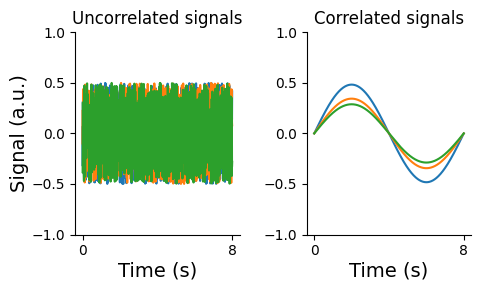

In [3]:
def plot_signal(data, title, ax):
    ax.plot(data[0, 0])
    ax.plot(data[1, 0])
    ax.plot(data[2, 0])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title(title)
    ax.set_ylim([-1, 1])
    ax.set_xlabel("Time (s)", fontsize=14, labelpad=2)
    ax.set_xticks([0, 1000])
    ax.set_xticklabels([0, 8])
    
fig, axs = plt.subplots(1, 2, figsize=(5, 3))

plot_signal(uncorrelated_signal, "Uncorrelated signals", axs[0])
plot_signal(correlated_signal, "Correlated signals", axs[1])
axs[0].set_ylabel("Signal (a.u.)", fontsize=14, labelpad=2)
fig.tight_layout()

In [4]:
def get_synchronization(signal, pairs=400, dt=8, bin_dt=25, seed=42):
    # pairs: number of random neuron pairs to sample
    # dt: duration of each single bin
    # bin_dt: bin the data of this duration
    torch.manual_seed(seed)  # Results should not depend on this - but good to include for reproducibility 
    cross_covariance_tensor = spiking.compute_synchronization(signal, pairs, dt=8, bin_dt=bin_dt)
    synchronization_df = spiking.compute_synchronization_df(cross_covariance_tensor.mean(0), dt=bin_dt)
    
    mean_synchronization = synchronization_df.groupby("lag").mean()
    lag = mean_synchronization.index / 1000
    correlation = mean_synchronization["correlation"].values

    return lag.values, correlation

In [5]:
values, correlated_signal_cc = get_synchronization(correlated_signal)
values, uncorrelated_signal_cc = get_synchronization(uncorrelated_signal)

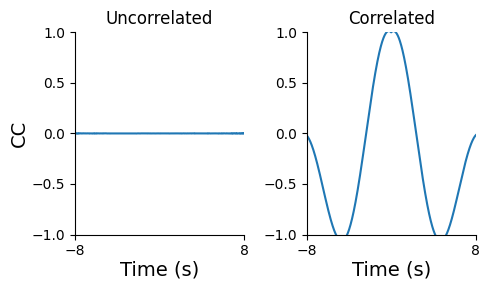

In [6]:
def plot_cc(values, signal_cc, title, ax):
    ax.plot(values, signal_cc)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title(title)
    ax.set_ylim([-1, 1])
    ax.set_xlabel("Time (s)", fontsize=14, labelpad=2)
    ax.set_xticks([-8, 8])
    ax.set_xlim([-8, 8])
    
fig, axs = plt.subplots(1, 2, figsize=(5, 3))

b, neuron_idx = 0, 0
plot_cc(values, uncorrelated_signal_cc, "Uncorrelated", axs[0])
plot_cc(values, correlated_signal_cc, "Correlated", axs[1])
axs[0].set_ylabel("CC", fontsize=14, labelpad=2)
fig.tight_layout()
fig.tight_layout()

As expected, the cross-correlogram of the uncorrelated data is completely flat - no correlations at different temporal lags; and the cross-correlogram of the correlated data showcases different correlations at various lags, with peak correlation at time equals zero.
